In [1]:
import torch
from bubbleformer.models import get_model
from bubbleformer.data import BubblemlForecast

In [2]:
# sat_92
test_path = ["/share/crsp/lab/ai4ts/share/BubbleML_f32/PoolBoiling-Saturated-FC72-2D-0.1/Twall-92.hdf5"]

# subcooled_100
# test_path = ["/share/crsp/lab/ai4ts/share/BubbleML_f32/PoolBoiling-SubCooled-FC72-2D-0.1/Twall-100.hdf5"]

# grav_0.2
# test_path = ["/share/crsp/lab/ai4ts/share/BubbleML_f32/PoolBoiling-Gravity-FC72-2D-0.1/gravY-0.2.hdf5"]

test_dataset = BubblemlForecast(
    filenames=test_path,
    fields=["dfun", "temperature", "velx", "vely"],
    norm="none",
    time_window=5,
    start_time=95
)

In [3]:
# model_name = "unet_modern"
# model_kwargs = {
#     "hidden_channels": 32,
#     "ch_mults": [1, 2, 2, 4, 4],
#     "norm": True
# }

# MoE Expert 6
# model_name = "avit_moe"
# model_kwargs = {
#     "fields": 4,  
#     "patch_size": 16,
#     "embed_dim": 384,
#     "processor_blocks": 12,
#     "num_heads": 6,
#     "drop_path": 0.2,
#     "n_experts": 6,
#     "n_shared_experts": 1,
#     "top_k": 2
# }
# model_kwargs = {
#             "fields": 4,
#             "patch_size": 16,
#             "embed_dim": 384,
#             "processor_blocks": 12,
#             "num_heads": 6,
#             "drop_path": 0.2,
#             "n_experts": 6,
#             "n_shared_experts": 1,
#             "top_k": 2,
#             "routed_expert_embed_dim": 192,
#             "shared_expert_type": "gelu",  # Options: "gelu" or "siren"
#             "shared_expert_embed_dim": 384  # Larger dimension for shared expert
# }

# MPP baseline model
model_name = "avit"
model_kwargs = {
    "fields": 4,  
    "patch_size": 16,
    "embed_dim": 384,
    "processor_blocks": 12,
    "num_heads": 6,
    "drop_path": 0.2
}

model = get_model(model_name, **model_kwargs)

In [4]:
from collections import OrderedDict
# weights_path = "/pub/sheikhh1/bubbleformer_logs/unet_modern_poolboiling_saturated_36055598/hpc_ckpt_8.ckpt"

# weight path for MoE Expert 6
# weights_path = "/share/crsp/lab/ai4ts/xianwz2/bubbleformer_modify/bubbleformer/bubbleformer_logs/E_6_S_1_A_2_avit_moe_poolboiling_combined_36230238/lightning_logs/version_0/checkpoints/epoch=398-step=199500.ckpt"
# weights_path = "/share/crsp/lab/amowli/xianwz2/bubbleformer_modify/bubbleformer/bubbleformer_logs/RED_192_SED_384_ST_gelu_E_6_S_1_A_2_avit_moe_poolboiling_saturated_37185925/lightning_logs/version_0/checkpoints/epoch=399-step=200000.ckpt"
weights_path = "/share/crsp/lab/amowli/xianwz2/bubbleformer_modify/bubbleformer/bubbleformer_logs/avit_poolboiling_saturated_37856288/lightning_logs/version_0/checkpoints/epoch=399-step=200000.ckpt"
# weight path for MPP baseline
# weights_path = "/share/crsp/lab/ai4ts/xianwz2/bubbleformer_modify/bubbleformer/bubbleformer_logs/Modified_Combined_avit_poolboiling_combined_36188451/lightning_logs/version_0/checkpoints/epoch=399-step=200000.ckpt"

model_data = torch.load(weights_path, weights_only=False)
print(model_data.keys())
diff_term, div_term = model_data['hyper_parameters']['normalization_constants']
diff_term = torch.tensor(diff_term)
div_term = torch.tensor(div_term)
weight_state_dict = OrderedDict()
for key, val in model_data["state_dict"].items():
    name = key[6:]
    weight_state_dict[name] = val
del model_data

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers', 'hparams_name', 'hyper_parameters'])


In [5]:
model.load_state_dict(weight_state_dict, strict=False)

<All keys matched successfully>

In [6]:
from bubbleformer.utils.losses import LpLoss
_, _ = test_dataset.normalize(diff_term, div_term)
criterion = LpLoss(d=2, p=2, reduce_dims=[0,1], reductions=["mean", "mean"])
model.eval()
start_time = test_dataset.start_time
skip_itrs = test_dataset.time_window
model_preds = []
model_targets = []
timesteps = []
for itr in range(0, 500, skip_itrs):
    inp, tgt = test_dataset[itr]
    print(f"Autoreg pred {itr}, inp tw [{start_time+itr}, {start_time+itr+skip_itrs}], tgt tw [{start_time+itr+skip_itrs}, {start_time+itr+2*skip_itrs}]")
    if len(model_preds) > 0:
        inp = model_preds[-1] # T, C, H, W 
        # print("Shape of inp:", inp.size()) # [5, 4, 512, 512]
    inp = inp.float().unsqueeze(0) # Add batch dimension
    # print("Shape of inp after unsqueeze:", inp.shape) # [1, 5, 4, 512, 512]
    pred = model(inp)
    # print("Size of pred:", pred.size()) # [1, 5, 4, 512, 512]
    pred = pred.squeeze(0).detach().cpu()
    # print("Shape of model_preds after squeeze:", pred.size()) # [5, 4, 512, 512]
    tgt = tgt.detach().cpu()
    # print("Size of tgt:", tgt.size()) # [5, 4, 512, 512]

    model_preds.append(pred)
    model_targets.append(tgt)
    timesteps.append(torch.arange(start_time+itr+skip_itrs, start_time+itr+2*skip_itrs))
    print(criterion(pred, tgt))


Autoreg pred 0, inp tw [95, 100], tgt tw [100, 105]
tensor(0.0596)
Autoreg pred 5, inp tw [100, 105], tgt tw [105, 110]
tensor(0.0912)
Autoreg pred 10, inp tw [105, 110], tgt tw [110, 115]
tensor(0.1213)
Autoreg pred 15, inp tw [110, 115], tgt tw [115, 120]
tensor(0.1587)
Autoreg pred 20, inp tw [115, 120], tgt tw [120, 125]
tensor(0.2059)
Autoreg pred 25, inp tw [120, 125], tgt tw [125, 130]
tensor(0.1846)
Autoreg pred 30, inp tw [125, 130], tgt tw [130, 135]
tensor(0.2118)
Autoreg pred 35, inp tw [130, 135], tgt tw [135, 140]
tensor(0.2608)
Autoreg pred 40, inp tw [135, 140], tgt tw [140, 145]
tensor(0.2825)
Autoreg pred 45, inp tw [140, 145], tgt tw [145, 150]
tensor(0.3155)
Autoreg pred 50, inp tw [145, 150], tgt tw [150, 155]
tensor(0.3175)
Autoreg pred 55, inp tw [150, 155], tgt tw [155, 160]
tensor(0.3435)
Autoreg pred 60, inp tw [155, 160], tgt tw [160, 165]
tensor(0.3629)
Autoreg pred 65, inp tw [160, 165], tgt tw [165, 170]
tensor(0.3953)
Autoreg pred 70, inp tw [165, 170], t

In [7]:
print("Size of model_preds:", len(model_preds))

Size of model_preds: 100


In [8]:
from bubbleformer.utils.plot_utils import plot_bubbleml


model_preds = torch.cat(model_preds, dim=0)         # T, C, H, W
# print("Shape of model_preds:", model_preds.shape) # [100, 4, 512, 512]
model_targets = torch.cat(model_targets, dim=0)     # T, C, H, W
timesteps = torch.cat(timesteps, dim=0)             # T,
num_var = len(test_dataset.fields)                  # C

preds = model_preds * div_term.view(1, num_var, 1, 1) + diff_term.view(1, num_var, 1, 1)     # denormalize
print("Shape of preds:", preds.shape)
targets = model_targets * div_term.view(1, num_var, 1, 1) + diff_term.view(1, num_var, 1, 1) # denormalize



Shape of preds: torch.Size([500, 4, 512, 512])


In [ ]:
# import os
# # weights_path = "/pub/sheikhh1/bubbleformer_logs/unet_modern_poolboiling_saturated_36055598/hpc_ckpt_8.ckpt"
# # save_dir = "/pub/sheikhh1/bubbleformer_logs/unet_modern_poolboiling_saturated_36055598/epoch_187_outputs/sat_92"

# ## MoE Expert 6
# ###### sat_92 
# save_dir = "/share/crsp/lab/amowli/xianwz2/bubbleformer_modify/bubbleformer/bubbleformer_logs/E_6_S_1_A_2_avit_moe_poolboiling_combined_36230238/epoch_398_outputs/sat_92"
# ###### subcooled_100
# # save_dir = "/share/crsp/lab/amowli/xianwz2/bubbleformer_modify/bubbleformer/bubbleformer_logs/E_6_S_1_A_2_avit_moe_poolboiling_combined_36230238/epoch_398_outputs/subcooled_100"
# ###### grav_0.2
# # save_dir = "/share/crsp/lab/amowli/xianwz2/bubbleformer_modify/bubbleformer/bubbleformer_logs/E_6_S_1_A_2_avit_moe_poolboiling_combined_36230238/epoch_398_outputs/grav_0.2"

# ## MPP baseline
# ###### sat_92 done
# # save_dir = "/share/crsp/lab/amowli/xianwz2/bubbleformer_modify/bubbleformer/bubbleformer_logs/Modified_Combined_avit_poolboiling_combined_36188451/epoch_399_outputs/sat_92"
# ###### subcooled_100
# # save_dir = "/share/crsp/lab/amowli/xianwz2/bubbleformer_modify/bubbleformer/bubbleformer_logs/Modified_Combined_avit_poolboiling_combined_36188451/epoch_399_outputs/subcooled_100"
# ###### grav_0.2
# # save_dir = "/share/crsp/lab/amowli/xianwz2/bubbleformer_modify/bubbleformer/bubbleformer_logs/Modified_Combined_avit_poolboiling_combined_36188451/epoch_399_outputs/grav_0.2"

# os.makedirs(save_dir, exist_ok=True)
# save_path = os.path.join(save_dir, "predictions.pt")

# torch.save({"preds": preds, "targets": targets, "timesteps": timesteps}, save_path)
# plot_bubbleml(preds, targets, timesteps, save_dir)

In [9]:
def test_eikonal_loss(phi):
    """
    phi = predicted sdf torch.Tensor(T,H,W)
    """
    dx = 1/32
    grad_x = (phi[:, :, 2:] - phi[:, :, :-2]) / (2 * dx)
    grad_y = (phi[:, 2:, :] - phi[:, :-2, :]) / (2 * dx)

    grad_x = torch.nn.functional.pad(grad_x, (1, 1), mode="replicate")
    grad_y = torch.nn.functional.pad(grad_y, (0, 0, 1, 1), mode="replicate")

    grad_magnitude = torch.sqrt(grad_x**2 + grad_y**2)
    loss_map = torch.abs(grad_magnitude - 1)
    mean_loss = torch.mean(loss_map, dim=(1, 2))
    return mean_loss

Average eikonal loss: 0.15561620891094208


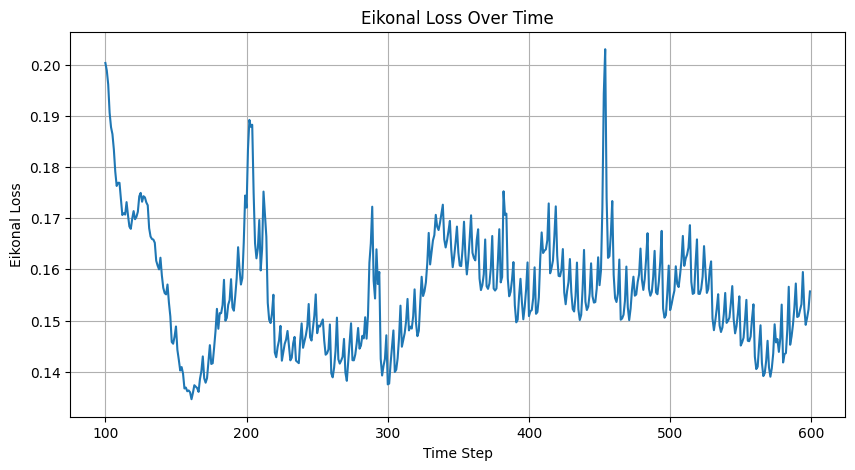

In [10]:
# preds has shape [100, 4, 512, 512] (T, C, H, W)
phi_preds = preds[:, 0]  # Shape: [100, 512, 512] → [T, H, W]  → only the φ field

# Apply the eikonal loss function
eikonal_losses = test_eikonal_loss(phi_preds)  # This will return losses of shape [100]

# Print average eikonal loss across all time steps
print(f"Average eikonal loss: {eikonal_losses.mean().item()}")

# Visualize the eikonal loss over time
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(timesteps.cpu().numpy(), eikonal_losses.cpu().numpy())
plt.xlabel('Time Step')
plt.ylabel('Eikonal Loss')
plt.title('Eikonal Loss Over Time')
plt.grid(True)
plt.show()

In [32]:
print(eikonal_losses)

tensor([0.2067, 0.2033, 0.1990, 0.1927, 0.1871, 0.1961, 0.1933, 0.1893, 0.1905,
        0.1863, 0.1899, 0.1851, 0.1827, 0.1792, 0.1797, 0.1817, 0.1800, 0.1775,
        0.1766, 0.1775, 0.1800, 0.1778, 0.1765, 0.1745, 0.1758, 0.1770, 0.1738,
        0.1727, 0.1730, 0.1735, 0.1716, 0.1724, 0.1740, 0.1739, 0.1738, 0.1705,
        0.1710, 0.1698, 0.1691, 0.1702, 0.1652, 0.1662, 0.1649, 0.1638, 0.1640,
        0.1606, 0.1620, 0.1622, 0.1632, 0.1637, 0.1586, 0.1585, 0.1582, 0.1605,
        0.1627, 0.1576, 0.1576, 0.1562, 0.1571, 0.1574, 0.1529, 0.1507, 0.1511,
        0.1515, 0.1535, 0.1502, 0.1493, 0.1522, 0.1532, 0.1555, 0.1522, 0.1503,
        0.1528, 0.1543, 0.1563, 0.1491, 0.1514, 0.1536, 0.1554, 0.1600, 0.1555,
        0.1565, 0.1574, 0.1602, 0.1646, 0.1604, 0.1592, 0.1608, 0.1614, 0.1650,
        0.1635, 0.1594, 0.1638, 0.1654, 0.1659, 0.1655, 0.1703, 0.1719, 0.1660,
        0.1700, 0.1654, 0.1624, 0.1627, 0.1653, 0.1688, 0.1660, 0.1662, 0.1676,
        0.1716, 0.1712, 0.1596, 0.1577, 

In [12]:
def test_heat_flux_loss(temperature, phi, k=1.0):
    """
    Calculates heat flux loss across interface boundaries
    
    Args:
        temperature: temperature field torch.Tensor(T, H, W)
        phi: SDF field torch.Tensor(T, H, W) 
        k: thermal conductivity coefficient (default=1.0)
    
    Returns:
        Heat flux loss tensor of shape [T]
    """
    dx = 1/32
    
    # Calculate temperature gradients
    grad_T_x = (temperature[:, :, 2:] - temperature[:, :, :-2]) / (2 * dx)
    grad_T_y = (temperature[:, 2:, :] - temperature[:, :-2, :]) / (2 * dx)
    
    # Pad the gradients to maintain original size
    grad_T_x = torch.nn.functional.pad(grad_T_x, (1, 1), mode="replicate")
    grad_T_y = torch.nn.functional.pad(grad_T_y, (0, 0, 1, 1), mode="replicate")
    
    # Calculate phi gradient (to identify interface)
    grad_phi_x = (phi[:, :, 2:] - phi[:, :, :-2]) / (2 * dx)
    grad_phi_y = (phi[:, 2:, :] - phi[:, :-2, :]) / (2 * dx)
    
    # Pad the gradients
    grad_phi_x = torch.nn.functional.pad(grad_phi_x, (1, 1), mode="replicate")
    grad_phi_y = torch.nn.functional.pad(grad_phi_y, (0, 0, 1, 1), mode="replicate")
    
    # Calculate heat flux magnitude: q = -k∇T
    heat_flux_magnitude = k * torch.sqrt(grad_T_x**2 + grad_T_y**2)
    
    # Find interface locations (where phi is close to zero)
    interface_mask = torch.abs(phi) < 0.02  # Adjust threshold as needed
    
    # Calculate normal vectors at interface (normalized phi gradient)
    normal_magnitude = torch.sqrt(grad_phi_x**2 + grad_phi_y**2)
    normal_magnitude = torch.clamp(normal_magnitude, min=1e-5)  # Avoid division by zero
    
    # At interface, heat flux should be continuous across the boundary
    # Loss is high where heat flux changes rapidly near interface
    flux_change = torch.abs(
        torch.diff(heat_flux_magnitude, dim=1, prepend=heat_flux_magnitude[:, :1, :]) + 
        torch.diff(heat_flux_magnitude, dim=2, prepend=heat_flux_magnitude[:, :, :1])
    )
    
    # Focus loss on interface regions
    interface_flux_loss = flux_change * interface_mask
    
    # Average loss per timestep
    mean_loss = torch.sum(interface_flux_loss, dim=(1, 2)) / (torch.sum(interface_mask, dim=(1, 2)) + 1e-6)
    
    return mean_loss

Average heat flux loss: 1.0490282773971558


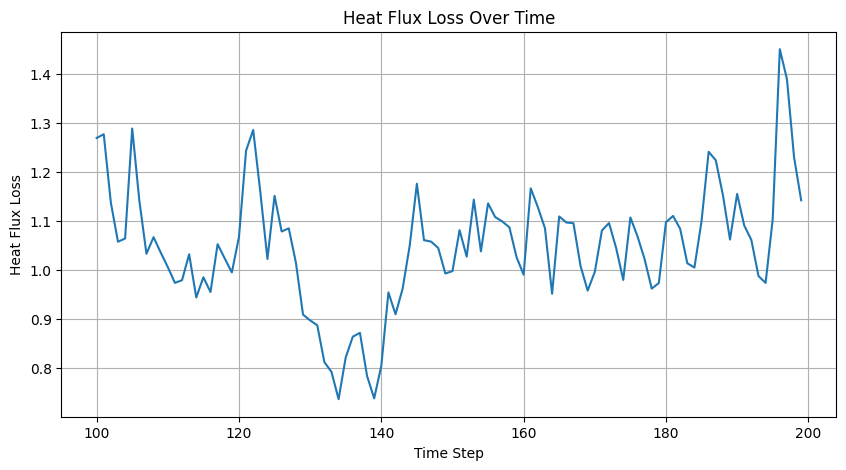

In [13]:
# preds has shape [T, C, H, W] where C is the number of fields (likely 5 based on your data)
phi_preds = preds[:, 0]      # dfun - Shape: [T, H, W]
temp_preds = preds[:, 2]     # temperature - Shape: [T, H, W]

# Apply the heat flux loss function
heat_flux_losses = test_heat_flux_loss(temp_preds, phi_preds)

# Print average heat flux loss across all time steps
print(f"Average heat flux loss: {heat_flux_losses.mean().item()}")

# Visualize the heat flux loss over time
plt.figure(figsize=(10, 5))
plt.plot(timesteps.cpu().numpy(), heat_flux_losses.cpu().numpy())
plt.xlabel('Time Step')
plt.ylabel('Heat Flux Loss')
plt.title('Heat Flux Loss Over Time')
plt.grid(True)
plt.show()